In [1]:
import cv2 
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train_dir = r'./aekdam_clean_crop_data/cleaned_crop/'

In [4]:
BATCH_SIZE = 32 
IMAGE_SIZE = (224,224) 

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, 
                                                            shuffle=True, 
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE, 
                                                            label_mode='categorical')
# class_names = sorted(os.listdir(train_dir))
# class_names_index = {i: class_names[i] for i in range(len(class_names))}
# class_names, class_names_index

train_dataset.classes

Found 4454 files belonging to 7 classes.


AttributeError: '_BatchDataset' object has no attribute 'classes'

In [19]:
train_batches = tf.data.experimental.cardinality(train_dataset) 
test_dataset = train_dataset.take(train_batches // 5) 
train_dataset = train_dataset.skip(train_batches // 5) 

In [20]:
tf.data.experimental.cardinality(train_dataset), tf.data.experimental.cardinality(test_dataset)

(<tf.Tensor: shape=(), dtype=int64, numpy=112>,
 <tf.Tensor: shape=(), dtype=int64, numpy=28>)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE 

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) 
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), 
    tf.keras.layers.RandomRotation(0.2), 
])

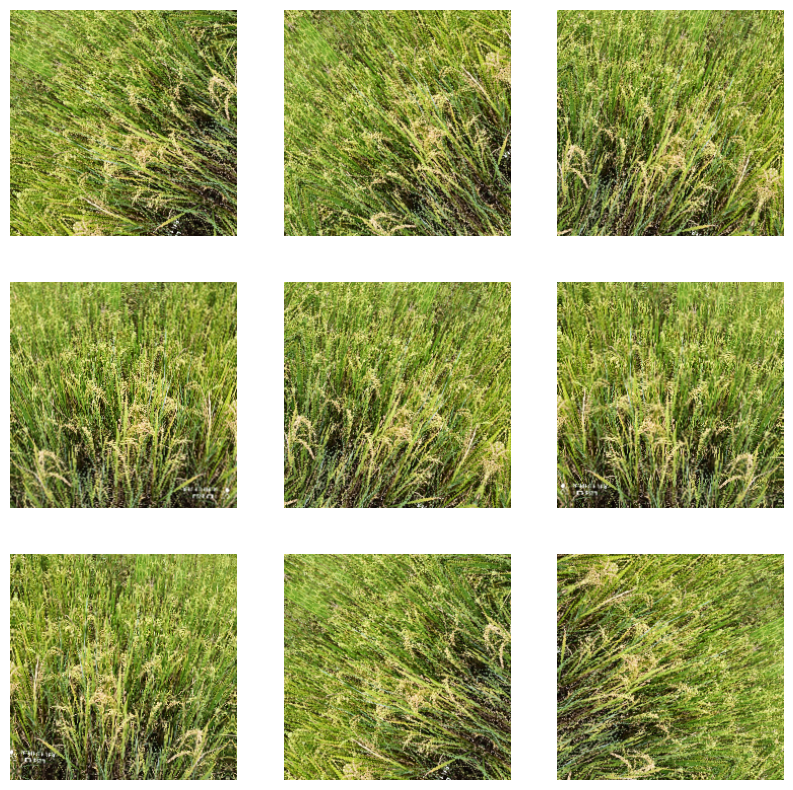

In [23]:
for image, _ in train_dataset.take(1): 
    plt.figure(figsize=(10, 10)) 
    first_image = image[0]
    for i in range(9): 
        ax = plt.subplot(3, 3, i+1) 
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) 
        plt.imshow(augmented_image[0]/255) 
        plt.axis('off')

In [24]:
class_names  = sorted(os.listdir(train_dir))

In [25]:
num_classes = len(np.unique(class_names)) 

input_shape = (224,224, 3) 

base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, 
                                               include_top=False, 
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset)) 

feature_batch = base_model(image_batch) 

base_model.trainable = True 

preprocess_input = tf.keras.applications.efficientnet.preprocess_input 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
feature_batch_average = global_average_layer(feature_batch) 

prediction_layer = tf.keras.layers.Dense(num_classes) 
prediction_batch = prediction_layer(feature_batch_average) 

inputs = tf.keras.Input(shape=input_shape) 
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False) 
x = global_average_layer(x) 
x = tf.keras.layers.Dropout(0.2)(x) 
outputs = prediction_layer(x) 
model = tf.keras.Model(inputs, outputs) 


model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 8967

In [26]:
len(model.trainable_variables)

213

In [27]:
base_learning_rate = 0.0001 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])
                                                            

In [28]:
initial_epoch = 10 
history = model.fit(train_dataset, 
                    epochs =initial_epoch, 
                    validation_data=test_dataset)

Epoch 1/10
112/112 [==============================] - 861s 7s/step - loss: 0.4947 - accuracy: 0.8260 - val_loss: 0.2063 - val_accuracy: 0.9275
Epoch 2/10
112/112 [==============================] - 786s 7s/step - loss: 0.1258 - accuracy: 0.9562 - val_loss: 0.4901 - val_accuracy: 0.8650
Epoch 3/10
112/112 [==============================] - 840s 7s/step - loss: 0.0780 - accuracy: 0.9761 - val_loss: 0.1347 - val_accuracy: 0.9576
Epoch 4/10
112/112 [==============================] - 872s 8s/step - loss: 0.0648 - accuracy: 0.9767 - val_loss: 0.1739 - val_accuracy: 0.9420
Epoch 5/10
112/112 [==============================] - 858s 7s/step - loss: 0.0440 - accuracy: 0.9857 - val_loss: 0.3253 - val_accuracy: 0.9029
Epoch 6/10
112/112 [==============================] - 838s 7s/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.1532 - val_accuracy: 0.9498
Epoch 7/10
112/112 [==============================] - 780s 7s/step - loss: 0.0302 - accuracy: 0.9902 - val_loss: 0.1630 - val_accuracy: 0.9375

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

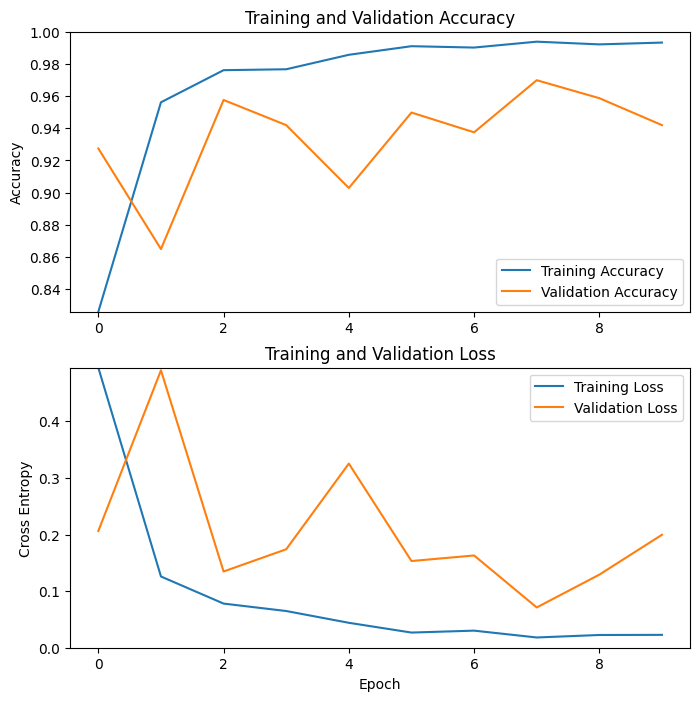

In [32]:
history_keys = history.history.keys()

if 'accuracy' in history_keys:
    acc = history.history['accuracy']  
if 'val_accuracy' in history_keys:
    val_acc = history.history['val_accuracy'] 
if 'loss' in history_keys:
    loss = history.history['loss'] 
if 'val_loss' in history_keys:
    val_loss = history.history['val_loss']  

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(min(acc), min(val_acc)), 1])  # Set the y-axis limits based on the data
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])  # Set the y-axis limits based on the data
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


In [54]:
model_path = r'models/effficient_net_crop_7_500_0.0001/10_2.h5'
model.save(model_path)

In [34]:
base_model.trainable = True 

print(len(base_model.layers)) 

fine_tune_at = 150 

for layer in base_model.layers[:fine_tune_at]: 
    layer.trainable=False

238


In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [47]:
fine_tune_epochs = 10

total_epochs = initial_epoch + fine_tune_epochs


history = model.fit(train_dataset, 
                    epochs =total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=test_dataset)

Epoch 10/20
112/112 [==============================] - 393s 3s/step - loss: 0.0889 - accuracy: 0.9689 - val_loss: 0.1294 - val_accuracy: 0.9680
Epoch 11/20
112/112 [==============================] - 388s 3s/step - loss: 0.0147 - accuracy: 0.9965 - val_loss: 0.0707 - val_accuracy: 0.9770
Epoch 12/20
112/112 [==============================] - 1531s 14s/step - loss: 0.0070 - accuracy: 0.9982 - val_loss: 0.0640 - val_accuracy: 0.9791
Epoch 13/20
112/112 [==============================] - 419s 3s/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0582 - val_accuracy: 0.9813
Epoch 14/20
112/112 [==============================] - 415s 4s/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0557 - val_accuracy: 0.9825
Epoch 15/20
112/112 [==============================] - 406s 3s/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0601 - val_accuracy: 0.9809
Epoch 16/20
112/112 [==============================] - 411s 3s/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0615 - val_accurac

In [55]:
saved_model_path = r'models/effficient_net_crop_7_tuning_150_0.0001/10_3.h5'
model.save(model_path)

In [50]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']



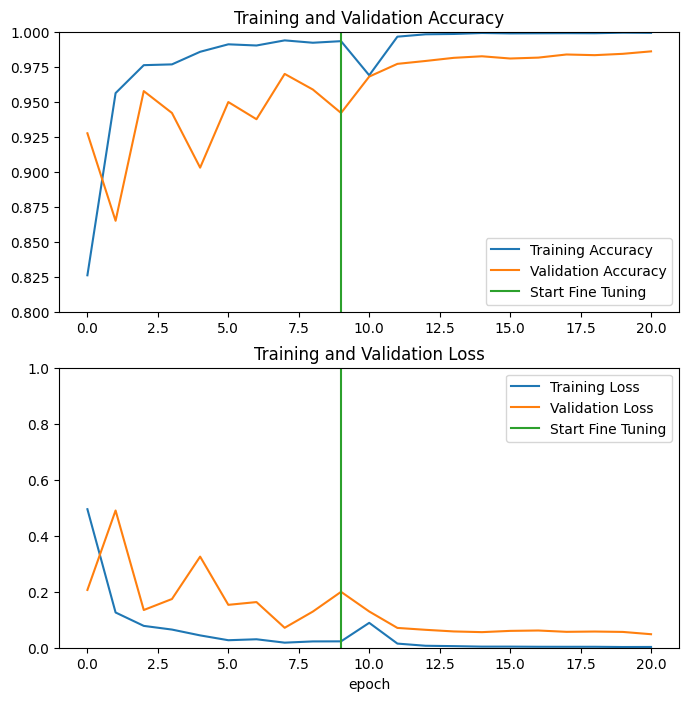

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
model_path = r'models/effficient_net_crop_7_tuning_150_0.0001/10.h5'
model.save(model_path)